# ALL IMPORTS

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

## Loading in dataset...

In [ ]:
student_mat = pd.read_table('/home/ics-home/Pearson Proj/Pearson/datasets/student-mat.csv', sep=";")

In [ ]:
# Taking a quick look
print(student_mat)

## 1. Initial look at the dataframe

**Histograms for Quantitative Variables**

In [ ]:
# Can make individual ones or one for each numeric column
# x-axis is the value and y-axis is the count
student_mat.hist(bins=20, figsize=(15, 10), color='green', alpha=0.5)
plt.suptitle('Histograms for All Numeric Columns in Math df')
plt.show()

## 2. Visualising Categorical and Quantitaive Vars. vs G3

**i. Boxplots for Categorical Variables vs G3**

In [ ]:
# List of Categorical Variables in Math df
cat_vars = [
    'sex', 'school', 'address', 
    'Pstatus', 'Mjob', 'Fjob', 
    'guardian', 'famsize', 'reason', 
    'schoolsup', 'famsup', 'activities', 
    'paid', 'internet', 'nursery', 
    'higher', 'romantic'
]

for cat_var in cat_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=student_mat, x=cat_var, y='G3')
    plt.title(f"G3 by {cat_var}")
    plt.xlabel(f"{cat_var}")
    plt.ylabel('G3')
    plt.show()

**ii. Bar Graphs for Quantitative Variables vs G3**

In [ ]:
# List of Numerical Vars in Math df
quan_vars = [
    "age", "Medu", "Fedu", "famrel", "traveltime", "studytime", "failures", 
    "freetime", "goout", "Walc", "Dalc", "health", "absences", "G1", "G2"
]

for quan_var in quan_vars:
    g3_means = student_mat.groupby(quan_var)['G3'].mean()
    g3_means.plot(kind='bar', title=f"Average G3 Score by {quan_var}", figsize=(8,5))
    plt.xlabel(f"{quan_var}")
    plt.ylabel('Average G3 Score')
    plt.show()

**ii. Boxplots for Quantitaive Variables vs. G3**

In [ ]:
for quan_var in quan_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=student_mat, x=quan_var, y='G3')
    plt.title(f"G3 by {quan_var}")
    plt.xlabel(f"{quan_var}")
    plt.ylabel('G3')
    plt.show()

## 3. Picking vars to focus on

## 4a. Chi-Square Tests on Categorical Vars

***For categorical variables, needed to change the G3 scores from integers to letter grades for chi-square test.***

In [41]:
# Function to assign letter grades
def assign_grade(score):
    if 16 <= score <= 20:
        return 'A'
    elif 14 <= score <= 15:
        return 'B'
    elif 12 <= score <= 13:
        return 'C'
    elif 10 <= score <= 11:
        return 'D'
    else:
        return 'F'

# Apply function to each grading period
for col, letter_col in zip(["G1", "G2", "G3"], ["L1", "L2", "L3"]):
    student_mat[letter_col] = student_mat[col].apply(assign_grade)

In [46]:
# Function for running chi-square test
def perform_chi_square_test(data, col1, col2):
    # creating contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # performing the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # interpreting the result
    significant = p < 0.05 #5% significance level
    return chi2, p, significant

In [56]:
# Categorical Vars of Interest
cat_vars_to_test = {
    "Student's School and Academic Performance": ('school', 'L2'),
    "Student's Address and Academic Performance": ('address', 'L2'),
    "Internet Access and Academic Performance": ('internet', 'L2'),
    "Mother's Job and Academic Performance": ('Mjob', 'L1'),
    "Father's Job and Academic Performance": ('Fjob', 'L1'),
    "School Support and Academic Performance": ('schoolsup', 'L3'),
    "Desire for Higher Education and Academic Performance": ('higher', 'L3')
}

results = {aspect: perform_chi_square_test(student_mat, *columns) for aspect, columns in cat_vars_to_test.items()}
chi_square_results = pd.DataFrame(results)
chi_square_results

,Student's School and Academic Performance,Student's Address and Academic Performance,Internet Access and Academic Performance,Mother's Job and Academic Performance,Father's Job and Academic Performance,School Support and Academic Performance,Desire for Higher Education and Academic Performance
0,2.121064,8.311809,8.088663,36.165282,30.987292,14.77708,13.164036
1,0.713504,0.080801,0.088384,0.002744,0.013507,0.005187,0.010501
2,False,False,False,True,True,True,True


## 4b. T-Tests on Quantitative Vars

In [51]:
# Quantitaive Vars of Interest
quan_vars_focus = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'health', 'G1', 'G2'
]

In [54]:
G3_median = student_mat['G3'].median()
student_mat['G3_median'] = student_mat['G3'].apply(lambda x: 'low' if x < G3_median else 'high')

results = []
for quan_var in quan_vars_focus:
    low = student_mat[student_mat['G3_median'] == 'low'][quan_var]
    high = student_mat[student_mat['G3_median'] == 'high'][quan_var]

    t_stat, p_value = stats.ttest_ind(low, high, equal_var = False)

    results.append({"Variable": quan_var, "T-test": t_stat, "P-value": p_value})

ttest_results = pd.DataFrame(results)
ttest_results.sort_values("P-value")

ttest_results['Statistically Significant'] = ttest_results['P-value'] < 0.05
ttest_results.sort_values('Statistically Significant')

,Variable,T-test,P-value,Statistically Significant
6,health,0.209455,8.342017e-01,False
0,age,3.060949,2.363520e-03,True
1,Medu,-3.293890,1.079537e-03,True
2,Fedu,-3.477660,5.630071e-04,True
3,traveltime,2.685073,7.590143e-03,True
4,studytime,-2.010697,4.504070e-02,True
5,failures,6.547461,3.905427e-10,True
7,G1,-23.189219,1.091113e-74,True
8,G2,-22.750550,6.730350e-72,True


# Linear Regression w/ "Naive Model"

**1. Split the data randomly into training (75%) and testing (25%) sets**

In [70]:
# List of variables we want to focus on (based on visuals and tests)
cat_vars = ['Mjob', 'Fjob', 'schoolsup', 'higher']
quan_vars = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'G1', 'G2']

# Make a subset of the variables we want to focus on
cat_vars_df = student_mat[cat_vars]
quan_vars_df = student_mat[quan_vars]

grade = student_mat['G3']

# set seed using random_state = 4 to make reproduceable
num_train, num_test, grade_train, grade_test = train_test_split(quan_vars_df, grade, random_state = 4)
cat_train, cat_test, grade_train, grade_test = train_test_split(cat_vars_df, grade, random_state = 4)

Model with Mjob: MSE = 23.8384
Model with Fjob: MSE = 23.7591
Model with schoolsup: MSE = 23.7091
Model with higher: MSE = 22.3778


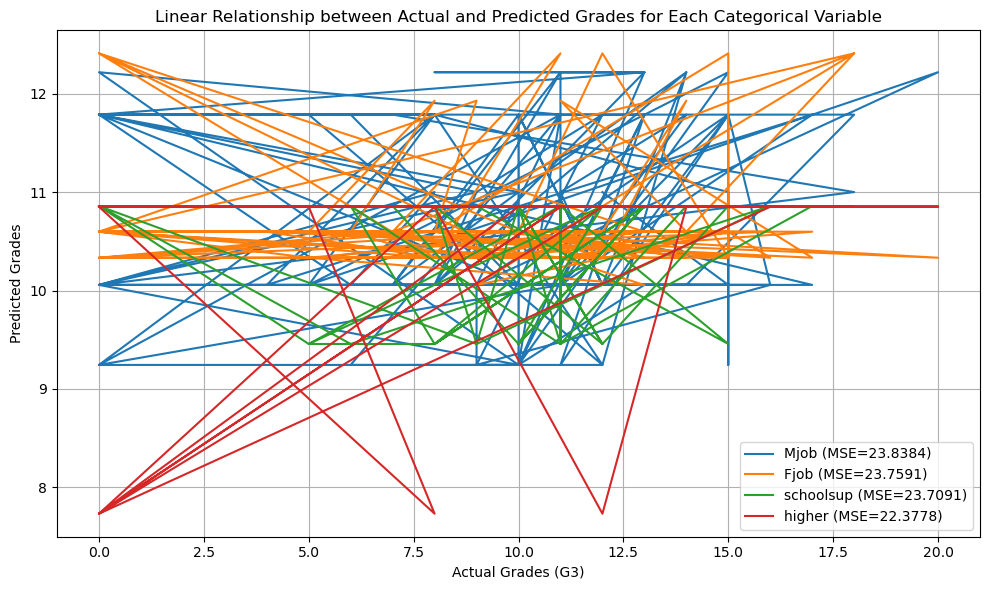

In [71]:
# Dictionary to store results
results = {}

# Create a figure for the linear graph
plt.figure(figsize=(10, 6))

for cat_var in cat_vars:
    # One-hot encode the single categorical variable
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    cat_train_encoded = encoder.fit_transform(cat_train[[cat_var]])
    cat_test_encoded = encoder.transform(cat_test[[cat_var]])

    # Convert to DataFrame
    cat_train_df = pd.DataFrame(cat_train_encoded, columns=encoder.get_feature_names_out([cat_var]))
    cat_test_df = pd.DataFrame(cat_test_encoded, columns=encoder.get_feature_names_out([cat_var]))

    # Train Linear Regression model using only the encoded categorical variables
    model = LinearRegression()
    model.fit(cat_train_df, grade_train)

    # Predictions
    y_pred = model.predict(cat_test_df)

    # Evaluate model
    mse = mean_squared_error(grade_test, y_pred)
    results[cat_var] = mse
    print(f"Model with {cat_var}: MSE = {mse:.4f}")

    # Plotting the linear graph (predictions vs actual values)
    plt.plot(grade_test.values, y_pred, label=f'{cat_var} (MSE={mse:.4f})')

# Customize the graph
plt.xlabel('Actual Grades (G3)')
plt.ylabel('Predicted Grades')
plt.title('Linear Relationship between Actual and Predicted Grades for Each Categorical Variable')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**2. With training data, fit linear regression models** 

***Categorical Models***

In [61]:
# Side Quest: Must turn categorical variables into numerical for the models

# Using One-Hot, encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Avoid dummy variable trap
cat_train_encoded = encoder.fit_transform(cat_train)
cat_test_encoded = encoder.transform(cat_test)

In [63]:
# Making model
cat_model = LinearRegression()

**3. With testing data, compute RMSE**